In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

zip_path = "/content/drive/MyDrive/hsi_data_pca.zip"
!unzip -o "{zip_path}" -d /content/hsi_data
!ls -lh /content/hsi_data/preprocessedd

Mounted at /content/drive
Archive:  /content/drive/MyDrive/hsi_data_pca.zip
  inflating: /content/hsi_data/preprocessed/y_train.npy  
  inflating: /content/hsi_data/preprocessed/y_test.npy  
  inflating: /content/hsi_data/preprocessed/X_test.npy  
  inflating: /content/hsi_data/preprocessed/X_train.npy  
  inflating: /content/hsi_data/preprocessedd/y_train.npy  
  inflating: /content/hsi_data/preprocessedd/y_test.npy  
  inflating: /content/hsi_data/preprocessedd/X_test.npy  
  inflating: /content/hsi_data/preprocessedd/X_train.npy  
total 734M
-rw-r--r-- 1 root root 661M Sep  8 10:24 X_test.npy
-rw-r--r-- 1 root root  73M Sep  8 10:24 X_train.npy
-rw-r--r-- 1 root root  73K Sep  8 10:24 y_test.npy
-rw-r--r-- 1 root root 8.1K Sep  8 10:24 y_train.npy


In [2]:
import numpy as np

X_train = np.load("/content/hsi_data/preprocessedd/X_train.npy")
X_test  = np.load("/content/hsi_data/preprocessedd/X_test.npy")
y_train = np.load("/content/hsi_data/preprocessedd/y_train.npy")
y_test  = np.load("/content/hsi_data/preprocessedd/y_test.npy")

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1018, 25, 25, 30) (9231, 25, 25, 30)
(1018,) (9231,)


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import CosineAnnealingLR


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [20]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes: (1018, 25, 25, 30) (9231, 25, 25, 30) (1018,) (9231,)


In [21]:
class HSI_Dataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].astype(np.float32)
        y = self.y[idx]

        if self.augment:
            # Simple augmentation: add Gaussian noise
            x = x + np.random.normal(0, 0.01, x.shape).astype(np.float32)

        return torch.tensor(x), torch.tensor(y)

# Create datasets
train_dataset = HSI_Dataset(X_train, y_train, augment=True)
test_dataset  = HSI_Dataset(X_test, y_test, augment=False)

# Dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [22]:
# 3D Conv Branch
class Branch3DConv(nn.Module):
    def __init__(self, in_bands, out_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self, x):
        x = x.permute(0,3,1,2).unsqueeze(1)  # [B,1,bands,H,W]
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        return self.fc(out)

In [23]:
# 1D Haar
class BranchHaar1D(nn.Module):
    def __init__(self, in_bands, out_dim=128):
        super().__init__()
        self.fc = None
        self.out_dim = out_dim

    def forward(self, x):
        x_avg = x.mean(-3).mean(-2)  # [B, bands]
        coeffs_list = []
        for i in range(x_avg.shape[0]):
            arr = x_avg[i].detach().cpu().numpy()
            cA, cD = pywt.dwt(arr, 'haar')
            coeffs_list.append(np.concatenate([cA, cD]))
        coeffs = torch.tensor(np.stack(coeffs_list), dtype=torch.float32, device=x.device)
        if self.fc is None:
            self.fc = nn.Linear(coeffs.shape[1], self.out_dim).to(x.device)
        return self.fc(coeffs)

# 2D Haar
class BranchHaar2D(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        self.fc = None
        self.out_dim = out_dim

    def forward(self, x):
        x_avg = x.mean(-1)  # [B,H,W]
        coeffs_list = []
        for i in range(x_avg.shape[0]):
            arr = x_avg[i].detach().cpu().numpy()
            cA, (cH, cV, cD) = pywt.dwt2(arr, 'haar')
            coeffs_list.append(np.concatenate([cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()]))
        coeffs = torch.tensor(np.stack(coeffs_list), dtype=torch.float32, device=x.device)
        if self.fc is None:
            self.fc = nn.Linear(coeffs.shape[1], self.out_dim).to(x.device)
        return self.fc(coeffs)

# 3D Haar
class BranchHaar3D(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        self.fc = None
        self.out_dim = out_dim

    def forward(self, x):
        x_perm = x.permute(0,3,1,2)
        coeffs_list = []
        for i in range(x_perm.shape[0]):
            temp_list = []
            for b in range(x_perm.shape[1]):
                arr = x_perm[i,b].detach().cpu().numpy()
                cA, cD = pywt.dwt(arr, 'haar')
                temp_list.append(np.concatenate([cA.flatten(), cD.flatten()]))
            coeffs_list.append(np.concatenate(temp_list))
        coeffs = torch.tensor(np.stack(coeffs_list), dtype=torch.float32, device=x.device)
        if self.fc is None:
            self.fc = nn.Linear(coeffs.shape[1], self.out_dim).to(x.device)
        return self.fc(coeffs)

In [46]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channel, channel // reduction)
        self.fc2 = nn.Linear(channel // reduction, channel)

    def forward(self, x):
        y = x.mean(dim=0, keepdim=True)    # global squeeze
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        return x * y                       # scale features

class MultiBranchModelSE(nn.Module):
    def __init__(self, in_bands, num_classes, out_dim=128):
        super().__init__()
        self.branch1 = Branch3DConv(in_bands, out_dim)
        self.branch2 = BranchHaar1D(in_bands, out_dim)
        self.branch3 = BranchHaar2D(out_dim)
        self.branch4 = BranchHaar3D(out_dim)

        self.se1 = SEBlock(out_dim)
        self.se2 = SEBlock(out_dim)
        self.se3 = SEBlock(out_dim)
        self.se4 = SEBlock(out_dim)

        self.fc1 = nn.Linear(out_dim*4, 512)
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        b1 = self.se1(self.branch1(x))
        b2 = self.se2(self.branch2(x))
        b3 = self.se3(self.branch3(x))
        b4 = self.se4(self.branch4(x))
        fused = torch.cat([b1,b2,b3,b4], dim=1)
        fused = F.relu(self.fc1(fused))
        fused = self.dropout(fused)
        return self.fc2(fused)

In [47]:
in_bands = X_train.shape[3]   # [B,H,W,bands]
num_classes = len(np.unique(y_train))

model = MultiBranchModelSE(in_bands, num_classes, out_dim=128).to(device)
print(model)

MultiBranchModelSE(
  (branch1): Branch3DConv(
    (conv): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (7): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): AdaptiveAvgPool3d(output_size=1)
    )
    (fc): Linear(in_features=64, out_features=128, bias=True)
  )
  (branch2): BranchHaar1D()
  (branch3): BranchHaar2D()
  (branch4): BranchHaar3D()
  (se1): SEBlock(
    (fc1): Linear(in_features=128, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=128, bias=True)
  )

In [48]:
num_epochs = 200


In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

In [50]:
from tqdm import tqdm
import matplotlib.pyplot as plt

best_val_loss = np.inf

train_losses, val_losses = [], []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    # --- Training Loop ---
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for X_batch, y_batch in train_loader_tqdm:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        train_loader_tqdm.set_postfix({"loss": loss.item()})

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # --- Validation Loop ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        val_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for X_batch, y_batch in val_loader_tqdm:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
            loss = criterion(out, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            val_loader_tqdm.set_postfix({"val_loss": loss.item()})

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    val_acc = correct / total * 100
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

    scheduler.step(val_loss)

    # --- Save checkpoint if best validation loss ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Checkpoint saved at epoch {epoch+1}")

# --- Plot Validation Accuracy ---
plt.figure(figsize=(10,5))
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Epoch vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.65it/s, val_loss=6.02]


Epoch 1: Train Loss=2.0163, Val Loss=1.8293, Val Acc=41.08%
Checkpoint saved at epoch 1


Epoch 2/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.98it/s, val_loss=4.82]


Epoch 2: Train Loss=1.1749, Val Loss=1.1636, Val Acc=60.70%
Checkpoint saved at epoch 2


Epoch 3/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.84it/s, val_loss=1.95]


Epoch 3: Train Loss=0.8200, Val Loss=0.7881, Val Acc=77.11%
Checkpoint saved at epoch 3


Epoch 4/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.63it/s, val_loss=1.97]


Epoch 4: Train Loss=0.5960, Val Loss=0.9462, Val Acc=65.26%


Epoch 5/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.73it/s, val_loss=0.832]


Epoch 5: Train Loss=0.4511, Val Loss=0.5259, Val Acc=84.94%
Checkpoint saved at epoch 5


Epoch 6/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.83it/s, val_loss=1.02]


Epoch 6: Train Loss=0.3149, Val Loss=0.6170, Val Acc=78.62%


Epoch 7/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.91it/s, val_loss=0.919]


Epoch 7: Train Loss=0.2368, Val Loss=0.4139, Val Acc=86.69%
Checkpoint saved at epoch 7


Epoch 8/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.84it/s, val_loss=1.03]


Epoch 8: Train Loss=0.1780, Val Loss=0.4082, Val Acc=86.33%
Checkpoint saved at epoch 8


Epoch 9/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.82it/s, val_loss=0.823]


Epoch 9: Train Loss=0.1283, Val Loss=0.4262, Val Acc=85.59%


Epoch 10/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.77it/s, val_loss=0.678]


Epoch 10: Train Loss=0.1028, Val Loss=0.4354, Val Acc=85.43%


Epoch 11/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.65it/s, val_loss=1.01]


Epoch 11: Train Loss=0.0795, Val Loss=0.3923, Val Acc=87.10%
Checkpoint saved at epoch 11


Epoch 12/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.83it/s, val_loss=0.75]


Epoch 12: Train Loss=0.0612, Val Loss=0.4112, Val Acc=86.53%


Epoch 13/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.74it/s, val_loss=0.686]


Epoch 13: Train Loss=0.0546, Val Loss=0.4055, Val Acc=86.59%


Epoch 14/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.92it/s, val_loss=0.759]


Epoch 14: Train Loss=0.0550, Val Loss=0.3661, Val Acc=88.14%
Checkpoint saved at epoch 14


Epoch 15/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.81it/s, val_loss=0.883]


Epoch 15: Train Loss=0.0348, Val Loss=0.3442, Val Acc=88.58%
Checkpoint saved at epoch 15


Epoch 16/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.92it/s, val_loss=0.733]


Epoch 16: Train Loss=0.0348, Val Loss=0.4606, Val Acc=84.74%


Epoch 17/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.79it/s, val_loss=0.51]


Epoch 17: Train Loss=0.0237, Val Loss=0.3637, Val Acc=88.14%


Epoch 18/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.58it/s, val_loss=0.797]


Epoch 18: Train Loss=0.0251, Val Loss=0.4178, Val Acc=86.59%


Epoch 19/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.48it/s, val_loss=0.851]


Epoch 19: Train Loss=0.0231, Val Loss=0.3580, Val Acc=88.79%


Epoch 20/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.42it/s, val_loss=0.757]


Epoch 20: Train Loss=0.0189, Val Loss=0.4785, Val Acc=85.67%


Epoch 21/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.64it/s, val_loss=0.933]


Epoch 21: Train Loss=0.0279, Val Loss=0.4749, Val Acc=84.96%


Epoch 22/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.65it/s, val_loss=0.967]


Epoch 22: Train Loss=0.0138, Val Loss=0.4287, Val Acc=87.23%


Epoch 23/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.75it/s, val_loss=0.975]


Epoch 23: Train Loss=0.0137, Val Loss=0.3545, Val Acc=88.57%


Epoch 24/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.70it/s, val_loss=0.829]


Epoch 24: Train Loss=0.0126, Val Loss=0.3648, Val Acc=88.74%


Epoch 25/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.88it/s, val_loss=0.766]


Epoch 25: Train Loss=0.0141, Val Loss=0.3787, Val Acc=88.66%


Epoch 26/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.87it/s, val_loss=0.97]


Epoch 26: Train Loss=0.0116, Val Loss=0.4022, Val Acc=88.04%


Epoch 27/200 [Val]: 100%|██████████| 577/577 [00:47<00:00, 12.03it/s, val_loss=0.645]


Epoch 27: Train Loss=0.0096, Val Loss=0.3621, Val Acc=89.04%


Epoch 28/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.96it/s, val_loss=0.48]


Epoch 28: Train Loss=0.0078, Val Loss=0.3988, Val Acc=88.33%


Epoch 29/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.67it/s, val_loss=0.565]


Epoch 29: Train Loss=0.0081, Val Loss=0.5977, Val Acc=83.47%


Epoch 30/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.82it/s, val_loss=0.951]


Epoch 30: Train Loss=0.0057, Val Loss=0.3880, Val Acc=88.91%


Epoch 31/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.67it/s, val_loss=0.966]


Epoch 31: Train Loss=0.0064, Val Loss=0.3635, Val Acc=89.21%


Epoch 32/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.67it/s, val_loss=0.652]


Epoch 32: Train Loss=0.0067, Val Loss=0.3911, Val Acc=88.65%


Epoch 33/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.72it/s, val_loss=0.983]


Epoch 33: Train Loss=0.0076, Val Loss=0.5899, Val Acc=83.54%


Epoch 34/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.49it/s, val_loss=0.456]


Epoch 34: Train Loss=0.0067, Val Loss=0.3696, Val Acc=89.23%


Epoch 35/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.54it/s, val_loss=1.38]


Epoch 35: Train Loss=0.0061, Val Loss=0.4340, Val Acc=87.79%


Epoch 36/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.52it/s, val_loss=1.21]


Epoch 36: Train Loss=0.0085, Val Loss=1.1713, Val Acc=74.98%


Epoch 37/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.55it/s, val_loss=1.13]


Epoch 37: Train Loss=0.0056, Val Loss=0.3736, Val Acc=89.26%


Epoch 38/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.61it/s, val_loss=1.19]


Epoch 38: Train Loss=0.0040, Val Loss=0.3872, Val Acc=89.07%


Epoch 39/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.71it/s, val_loss=0.87]


Epoch 39: Train Loss=0.0081, Val Loss=0.3804, Val Acc=89.32%


Epoch 40/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.52it/s, val_loss=0.845]


Epoch 40: Train Loss=0.0075, Val Loss=1.0742, Val Acc=76.41%


Epoch 41/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.69it/s, val_loss=1.11]


Epoch 41: Train Loss=0.0083, Val Loss=3.7287, Val Acc=54.40%


Epoch 42/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.63it/s, val_loss=0.789]


Epoch 42: Train Loss=0.0057, Val Loss=0.4091, Val Acc=88.13%


Epoch 43/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.61it/s, val_loss=0.927]


Epoch 43: Train Loss=0.0049, Val Loss=0.3903, Val Acc=88.84%


Epoch 44/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.63it/s, val_loss=0.74]


Epoch 44: Train Loss=0.0032, Val Loss=0.4318, Val Acc=88.04%


Epoch 45/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.51it/s, val_loss=0.658]


Epoch 45: Train Loss=0.0049, Val Loss=0.4117, Val Acc=88.67%


Epoch 46/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.61it/s, val_loss=0.728]


Epoch 46: Train Loss=0.0033, Val Loss=0.4623, Val Acc=87.38%


Epoch 47/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.49it/s, val_loss=0.604]


Epoch 47: Train Loss=0.0030, Val Loss=0.3928, Val Acc=89.21%


Epoch 48/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.61it/s, val_loss=0.639]


Epoch 48: Train Loss=0.0044, Val Loss=0.4197, Val Acc=88.40%


Epoch 49/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.60it/s, val_loss=0.719]


Epoch 49: Train Loss=0.0037, Val Loss=0.4118, Val Acc=88.53%


Epoch 50/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.76it/s, val_loss=0.779]


Epoch 50: Train Loss=0.0030, Val Loss=0.4220, Val Acc=88.53%


Epoch 51/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.60it/s, val_loss=0.792]


Epoch 51: Train Loss=0.0028, Val Loss=0.4803, Val Acc=87.42%


Epoch 52/200 [Val]: 100%|██████████| 577/577 [00:48<00:00, 11.79it/s, val_loss=1.03]


Epoch 52: Train Loss=0.0024, Val Loss=0.4069, Val Acc=89.04%


Epoch 53/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.52it/s, val_loss=1.05]


Epoch 53: Train Loss=0.0028, Val Loss=0.4126, Val Acc=88.70%


Epoch 54/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.70it/s, val_loss=0.667]


Epoch 54: Train Loss=0.0129, Val Loss=0.4387, Val Acc=88.19%


Epoch 55/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.67it/s, val_loss=0.716]


Epoch 55: Train Loss=0.0044, Val Loss=0.5296, Val Acc=86.34%


Epoch 56/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.53it/s, val_loss=0.998]


Epoch 56: Train Loss=0.0031, Val Loss=0.4931, Val Acc=87.17%


Epoch 57/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.62it/s, val_loss=0.741]


Epoch 57: Train Loss=0.0029, Val Loss=0.4203, Val Acc=88.79%


Epoch 58/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.43it/s, val_loss=0.733]


Epoch 58: Train Loss=0.0021, Val Loss=0.4230, Val Acc=88.64%


Epoch 59/200 [Val]: 100%|██████████| 577/577 [00:51<00:00, 11.31it/s, val_loss=0.853]


Epoch 59: Train Loss=0.0013, Val Loss=0.4308, Val Acc=88.90%


Epoch 60/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.44it/s, val_loss=0.882]


Epoch 60: Train Loss=0.0017, Val Loss=0.4293, Val Acc=88.73%


Epoch 61/200 [Val]: 100%|██████████| 577/577 [00:49<00:00, 11.63it/s, val_loss=0.858]


Epoch 61: Train Loss=0.0052, Val Loss=0.4401, Val Acc=88.69%


Epoch 62/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.54it/s, val_loss=0.773]


Epoch 62: Train Loss=0.0045, Val Loss=0.4273, Val Acc=88.53%


Epoch 63/200 [Val]: 100%|██████████| 577/577 [00:50<00:00, 11.38it/s, val_loss=0.879]


Epoch 63: Train Loss=0.0025, Val Loss=0.4832, Val Acc=87.31%


Epoch 64/200 [Val]: 100%|██████████| 577/577 [00:51<00:00, 11.29it/s, val_loss=0.916]


Epoch 64: Train Loss=0.0015, Val Loss=0.4218, Val Acc=89.06%


Epoch 65/200 [Val]:  39%|███▉      | 225/577 [00:18<00:29, 11.85it/s, val_loss=0.000714]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-1986396694.py", line 37, in <cell line: 0>
    out = model(X_batch)
          ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-33987874.py", line 34, in forward
    b4 = self.se4(self.branch4(x))
                  ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^

TypeError: object of type 'NoneType' has no len()

In [35]:
import matplotlib.pyplot as plt

# Load checkpoint
checkpoint = torch.load("checkpoint_epoch_59.pth", map_location=device)

# Extract lists (replace keys if your checkpoint used different names)
train_losses = checkpoint.get('train_losses', [])
val_losses = checkpoint.get('val_losses', [])
val_accs = checkpoint.get('val_accs', [])

epochs = range(1, len(train_losses)+1)

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint_epoch_59.pth'

In [36]:
import torch
from torch.utils.data import DataLoader

# --- Load the best model checkpoint ---
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

# --- Initialize metrics ---
test_loss = 0
correct = 0
total = 0

# --- Define criterion if not already defined ---
# criterion = torch.nn.CrossEntropyLoss()  # Already defined in your training code

# --- Test Loop ---
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader, desc="Testing")
    for X_batch, y_batch in test_loader_tqdm:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        test_loader_tqdm.set_postfix({"loss": loss.item()})

# --- Compute final metrics ---
test_loss /= len(test_loader.dataset)
test_acc = correct / total * 100

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Testing: 100%|██████████| 577/577 [00:51<00:00, 11.19it/s, loss=0.576]

Test Loss: 0.3277, Test Accuracy: 89.47%


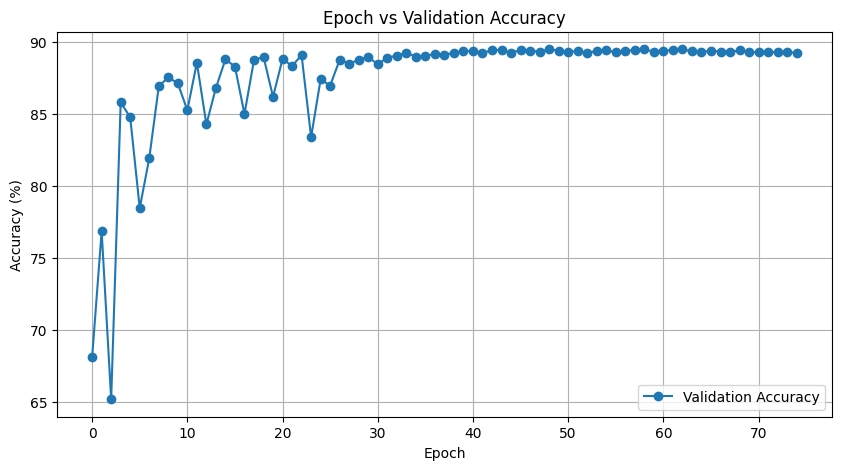

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')


plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Epoch vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
val_accuracies

[68.1291301050807,
 76.8497454230311,
 65.20420322825262,
 85.79785505362366,
 84.75788105297367,
 78.46387173653993,
 81.91961867619976,
 86.90282742931427,
 87.54197811721373,
 87.10865561694291,
 85.24536886577836,
 88.5494529303434,
 84.270393240169,
 86.79449680424656,
 88.7769472429856,
 88.27862636767414,
 84.98537536561585,
 88.72278193045175,
 88.9611093056007,
 86.17701224136063,
 88.8094464305059,
 88.32195861770123,
 89.06943993066841,
 83.3820821146138,
 87.40114830462572,
 86.95699274184811,
 88.74444805546527,
 88.48445455530279,
 88.74444805546527,
 88.95027624309392,
 88.43028924276894,
 88.89611093056007,
 89.03694074314808,
 89.23193586826996,
 88.97194236810746,
 88.993608493121,
 89.1777705557361,
 89.08027299317517,
 89.25360199328351,
 89.32943343083089,
 89.37276568085798,
 89.23193586826996,
 89.40526486837828,
 89.44859711840537,
 89.23193586826996,
 89.42693099339184,
 89.37276568085798,
 89.30776730581735,
 89.48109630592569,
 89.37276568085798,
 89.30776730